In [2]:
import numpy as np
import sipm.io.sipm as sipm
import sipm.io.dataset as ds
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sipm.util.functions import pulse_jitter
from scipy.fft import fft, ifft
import ROOT
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/06


In [3]:
!pwd

/home/as111/sipm-analysis


# Exponential pulses with time jitter
Scintillation pulse (one component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$
We include two scintillation pulse components with distinct $\tau$.

In [4]:
def scintillation_pulse(t, a_s, tau_s, a_t, tau_t, sigma, t0):
        return pulse_jitter(t, a_s, tau_s, sigma, t0) + pulse_jitter(t, a_t, tau_t, sigma, t0)

# Read SPE Waveform (65V)

In [5]:
pos = ['top', 'bottom']
spe_graph = []
spe_fft = []
for i,p in enumerate(pos):
    spe_pos = []
    spe_fft_pos = []
    for ch in range(4):
        file = ROOT.TFile('root/SPE_waveform_1122_65V_{}.root'.format(p))
        spe_ch = file.Get('gSPE_ch{}'.format(ch))
        spe_pos.append(spe_ch)
        file.Close()
        tpeak = np.argmax(np.array(list(spe_ch.GetY())))
        spe_fft_ch = fft(np.array(list(spe_ch.GetY())))
        for f in range(len(spe_fft_ch)):
            spe_fft_ch[f] *= np.exp(complex(0,2*np.pi*f*tpeak/len(spe_ch.GetY())))
        spe_fft_pos.append(spe_fft_ch)
    spe_graph.append(spe_pos)
    spe_fft.append(spe_fft_pos)
time = np.array(list(spe_graph[0][0].GetX()))
dt = time[1]-time[0]
freq = np.arange(time.size)/dt/time.size

(0.0, 124.96874406430315)

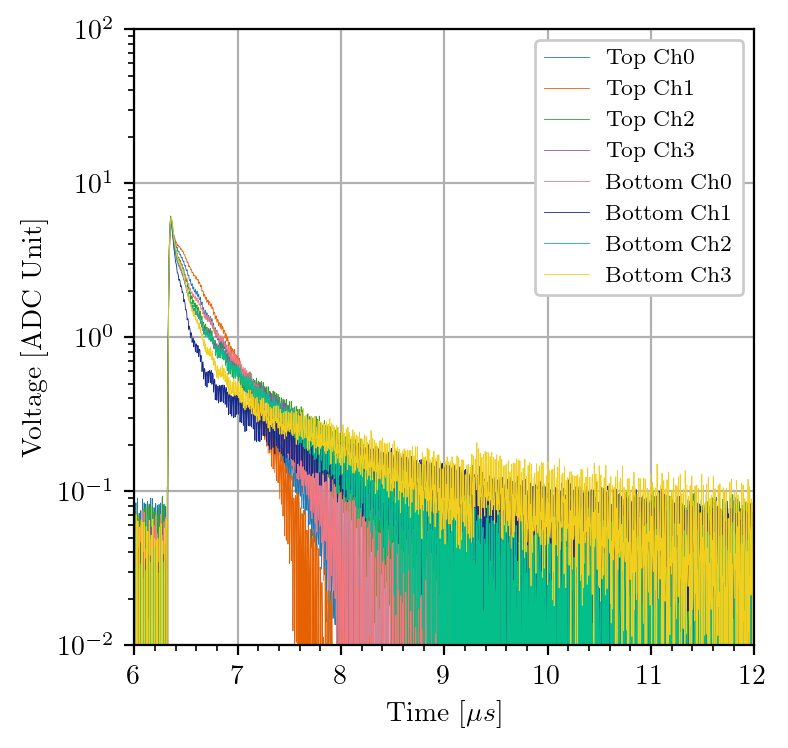

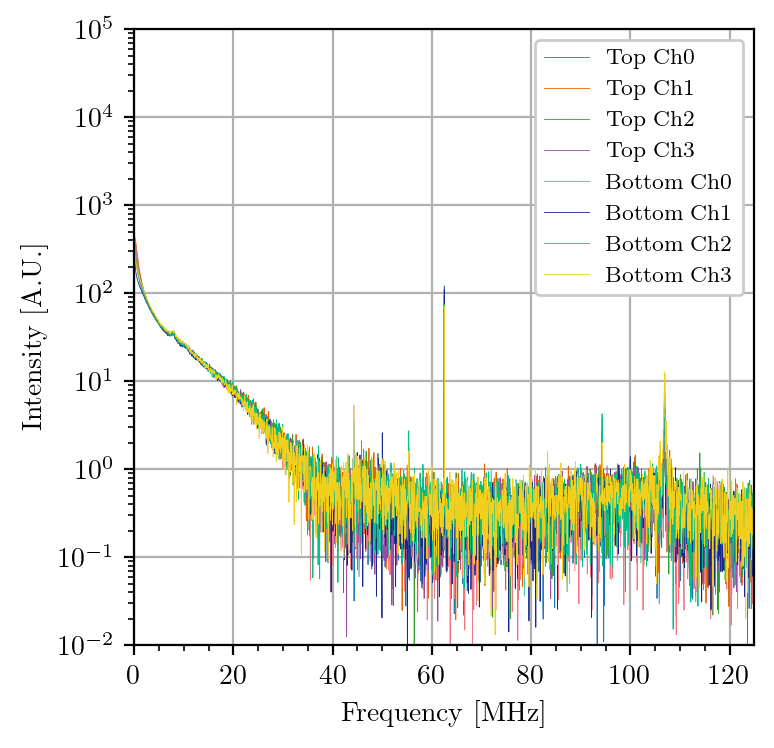

In [11]:
plt.figure(1,figsize=(4,4))
pos_label=['Top','Bottom']
for i,p in enumerate(pos_label):
    for ch in range(4):
        plt.plot(list(spe_graph[i][ch].GetX()), list(spe_graph[i][ch].GetY()), label='{} Ch{}'.format(p,ch), linewidth=0.3)
plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel(r'Voltage [ADC Unit]')
plt.yscale('log')
plt.minorticks_on()
plt.grid()
plt.ylim(1e-2, 1e2)
plt.xlim(6,12)

plt.figure(2,figsize=(4,4))
for i,p in enumerate(pos_label):
    for ch in range(4):
        plt.plot(freq, abs(spe_fft[i][ch]), label='{} Ch{}'.format(p,ch), linewidth=0.3)
plt.legend(loc='upper right')
plt.xlabel(r'Frequency [MHz]')
plt.ylabel(r'Intensity [A.U.]')
plt.yscale('log')
plt.minorticks_on()
plt.grid()
plt.ylim(1e-2,1e5)
plt.xlim(0,freq[-1]/2)

# 11/20 Triplet lifetime
Here the average waveforms are deconvolved channel-by-channel using their respective SPE pulse shapes.
The deconvolved waveform is given by
$$f_{deconv}(t) = \mathcal{F}^{-1}\left(\frac{\mathcal{F}(f_{original}(t))}{\mathcal{F}(f_{SiPM}(t))}\right)$$
Note that the SiPM pulse shape has to be shifted such that the trigger for it is at $t=0$.<br>

The average waveforms are selected from the events with $F_{\rm prompt}>0.1$ and $N_{\rm PE}>50$ ($N_{\rm PE}>300$) for the top (bottom). The energy threshold is roughly $300~\rm keV$.

ch0 A_S=1.04+/-0.07  TAU_S=0.0120+/-0.0010us  A_T=0.06+/-0.00  TAU_T=1.117+/-0.089us sigma=0.0034+/-0.0004us t0=6.275+/-0.000us
ch1 A_S=1.16+/-0.05  TAU_S=0.0151+/-0.0008us  A_T=0.08+/-0.00  TAU_T=1.226+/-0.074us sigma=0.0034+/-0.0003us t0=6.275+/-0.000us
ch2 A_S=1.14+/-0.07  TAU_S=0.0121+/-0.0009us  A_T=0.07+/-0.00  TAU_T=1.143+/-0.085us sigma=0.0034+/-0.0003us t0=6.275+/-0.000us
ch3 A_S=6.58+/-7.24  TAU_S=0.0016+/-0.0017us  A_T=0.08+/-0.00  TAU_T=0.961+/-0.079us sigma=0.0051+/-0.0005us t0=6.284+/-0.002us
ch0 A_S=2.85+/-0.10  TAU_S=0.0201+/-0.0009us  A_T=0.21+/-0.01  TAU_T=1.490+/-0.083us sigma=0.0033+/-0.0003us t0=6.286+/-0.000us
ch1 A_S=2.82+/-0.16  TAU_S=0.0180+/-0.0014us  A_T=0.21+/-0.01  TAU_T=1.332+/-0.102us sigma=0.0039+/-0.0004us t0=6.286+/-0.000us
ch2 A_S=3.99+/-0.14  TAU_S=0.0170+/-0.0008us  A_T=0.25+/-0.01  TAU_T=1.509+/-0.078us sigma=0.0037+/-0.0003us t0=6.279+/-0.000us
ch3 A_S=3.69+/-0.13  TAU_S=0.0193+/-0.0009us  A_T=0.29+/-0.01  TAU_T=1.294+/-0.069us sigma=0.0037+/-0.00

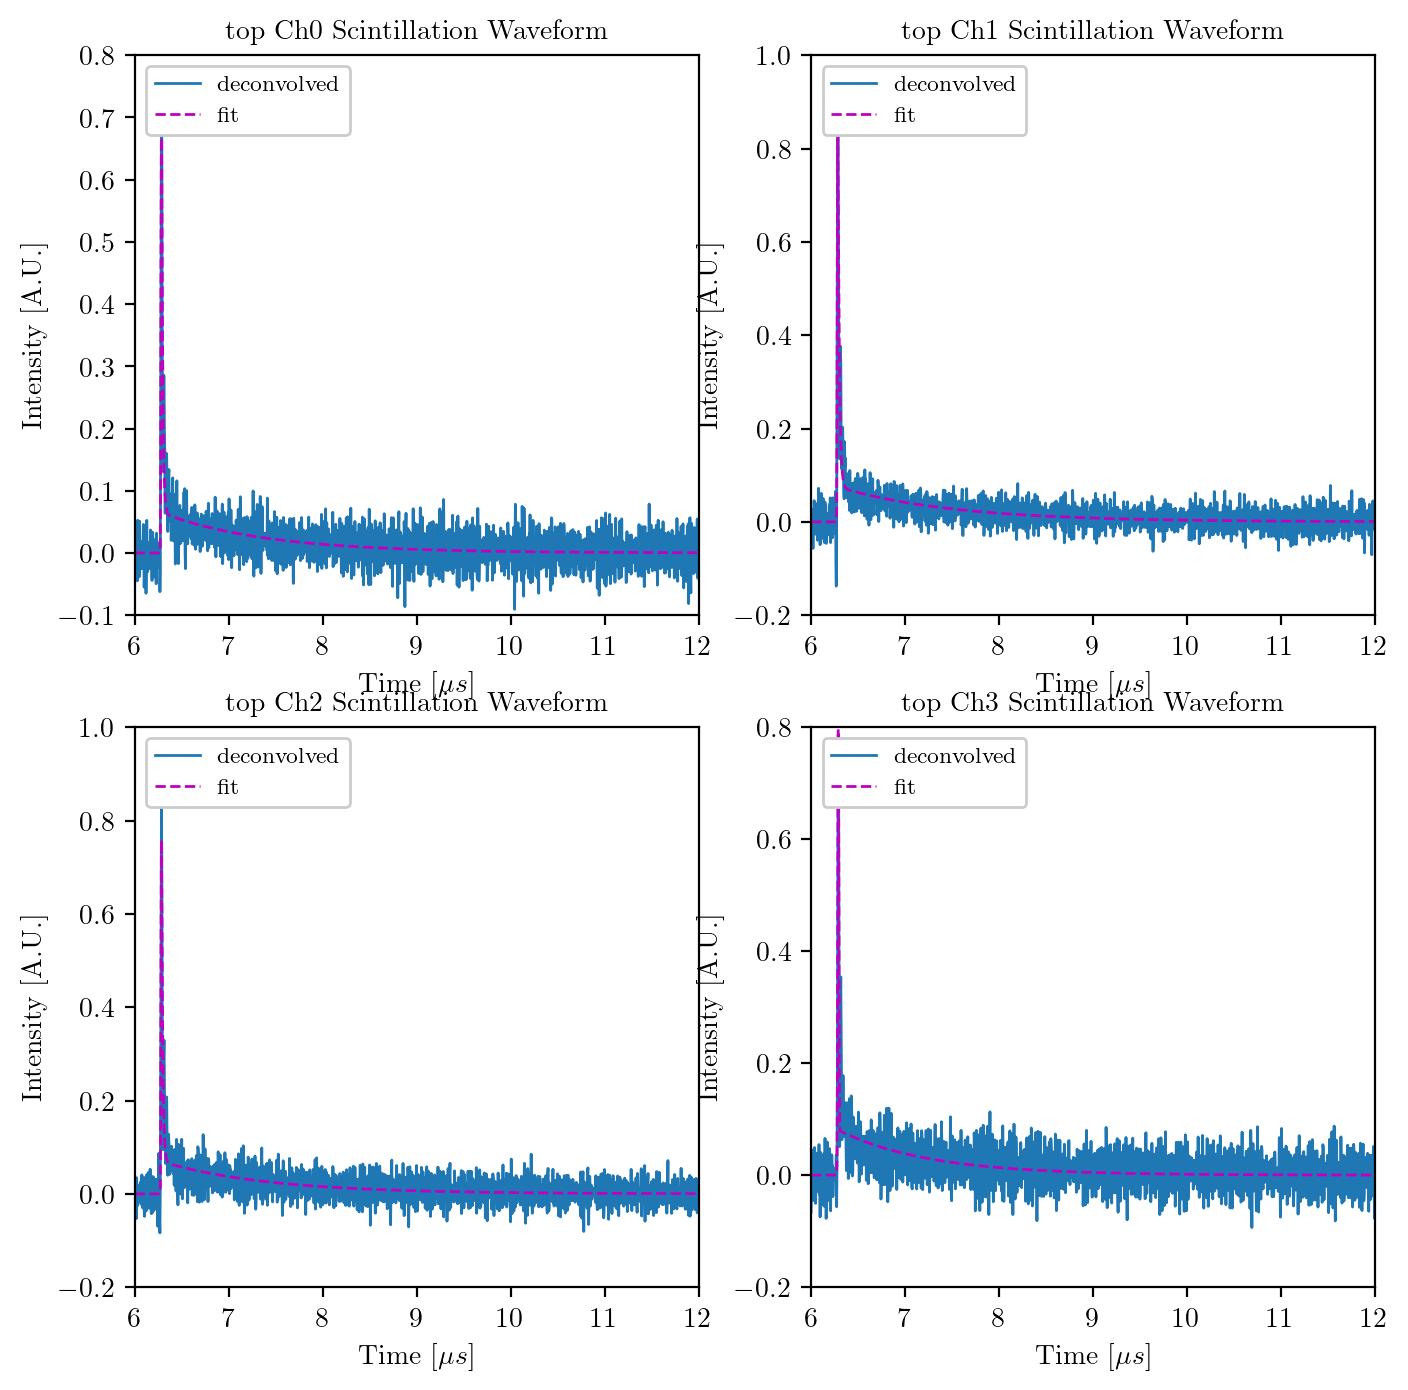

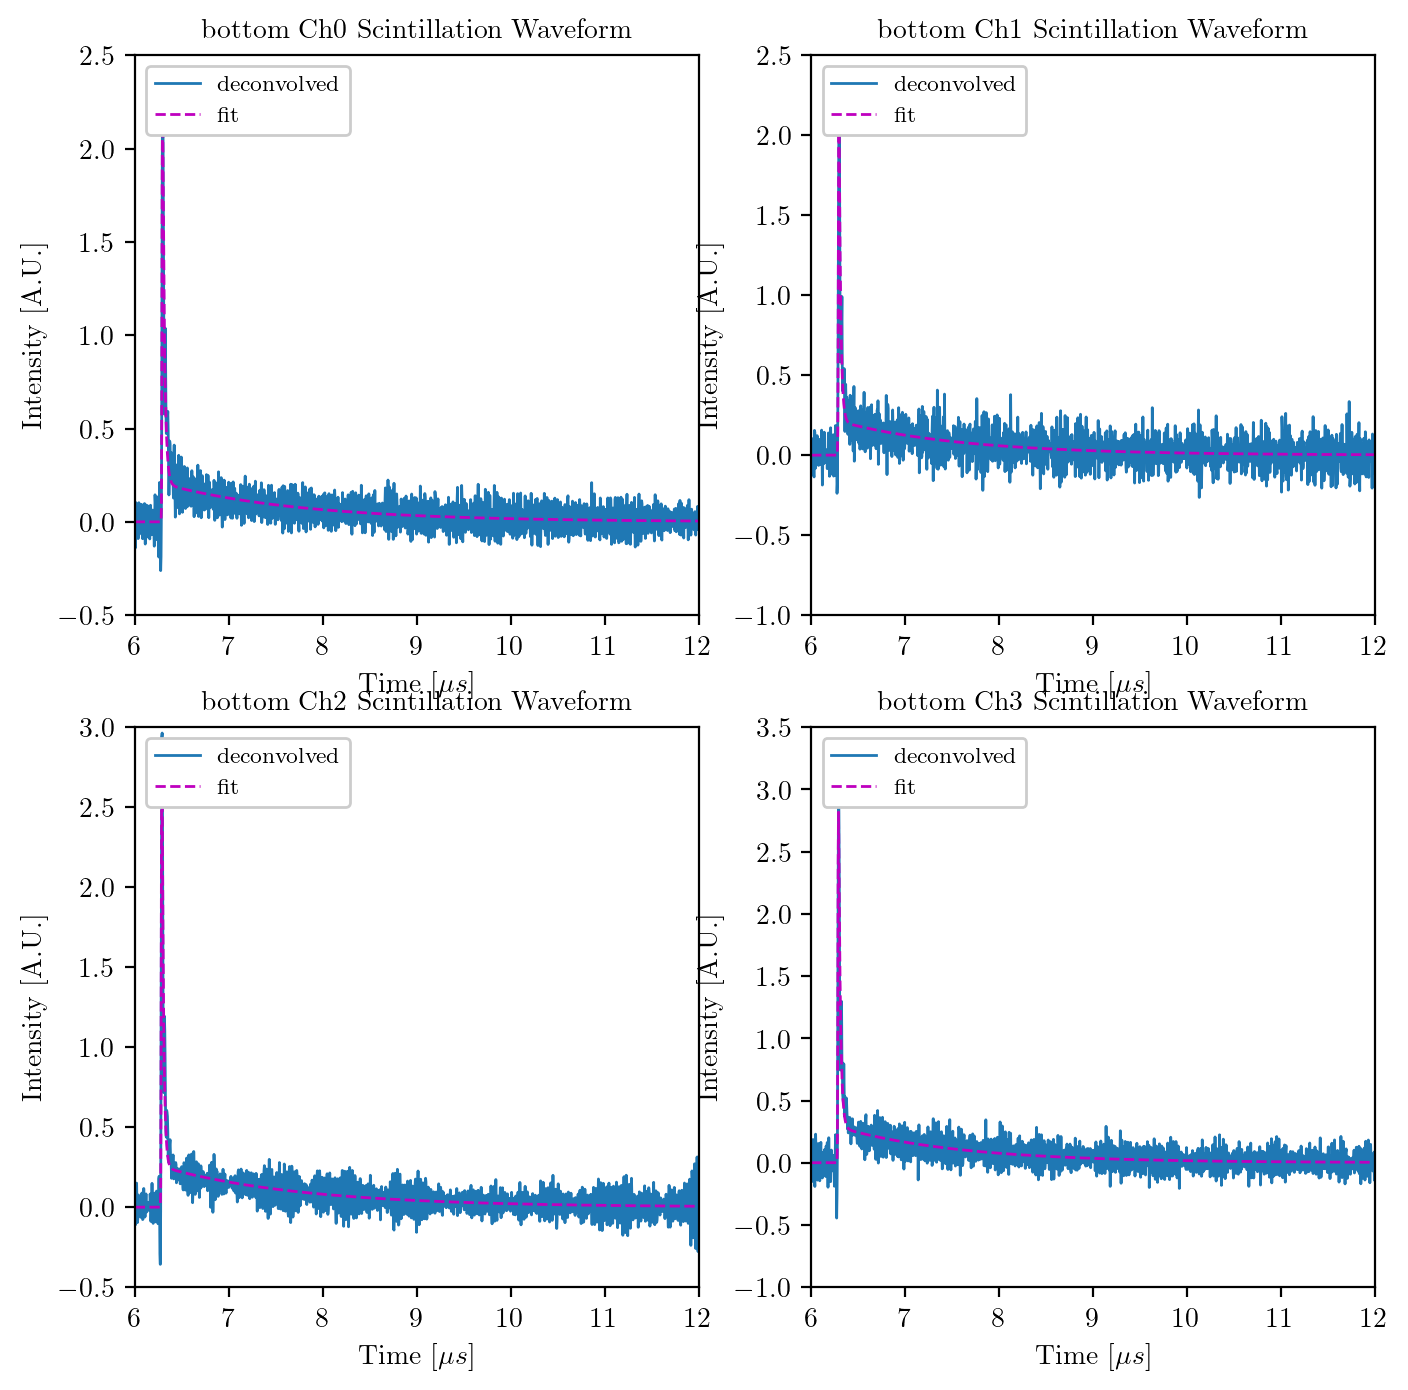

In [15]:
pos = ['top', 'bottom']
deconv1120 = []
triplet1120 = []
for i,p in enumerate(pos):
    deconv_pos = np.zeros(time.size)
    for ch in range(4):
        plt.figure(i,figsize=(8,8))
        file = ROOT.TFile('root/gamma_1120_65V_{}.root'.format(p))
        scint_graph = file.Get('gScintWf_ch{}'.format(ch))
        file.Close()
        deconv_ch = ifft(fft(np.array(list(scint_graph.GetY())))/spe_fft[i][ch]).real
        deconv_pos += deconv_ch

        t0 = np.argmax(deconv_ch)-int(0.1/dt)
        length = int(6/dt)
        bsl = np.argmax(deconv_ch)-int(0.5/dt)
        err = np.std(deconv_ch[:bsl])

        popt,pcov = curve_fit(scintillation_pulse,time[t0:t0+length], deconv_ch[t0:t0+length], p0=[2, 0.015, 0.1, 1.3, 0.0035, 6.28], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        
        plt.subplot(2,2,ch+1)
        plt.plot(time, deconv_ch, label='deconvolved', linewidth=1)
        plt.plot(time, scintillation_pulse(time, *popt), "m--", label='fit', linewidth=1)
        plt.title('{} Ch{} Scintillation Waveform'.format(pos[i],ch))
        plt.ylabel('Intensity [A.U.]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        plt.xlim(6,12)
    deconv1120.append(deconv_pos)

Now the deconvolved waveforms are summed over the channels and fitted by the functions calculated at the beginning.

ch3 A_S=4.05+/-0.14  TAU_S=0.0147+/-0.0006us  A_T=0.27+/-0.01  TAU_T=1.211+/-0.055us sigma=0.0035+/-0.0002us t0=6.276+/-0.000us
ch3 A_S=12.02+/-0.27  TAU_S=0.0212+/-0.0006us  A_T=0.93+/-0.02  TAU_T=1.437+/-0.047us sigma=0.0041+/-0.0002us t0=6.282+/-0.000us


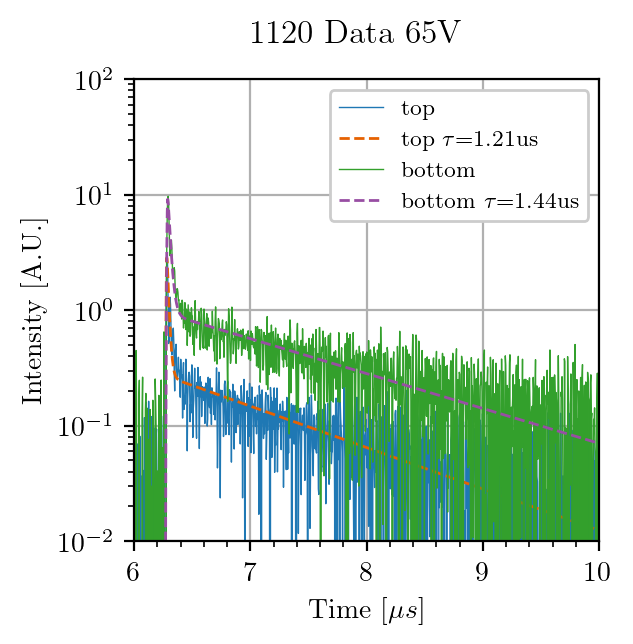

In [16]:
plt.figure(0,figsize=(3,3))
triplet1120 = []
for i,dc in enumerate(deconv1120):
    t0 = np.argmax(dc)-int(0.1/dt)
    length = int(6/dt)
    bsl = np.argmax(dc)-int(0.5/dt)
    err = np.std(dc[:bsl])

    popt,pcov = curve_fit(scintillation_pulse, time[t0:t0+length], dc[t0:t0+length], p0=[2, 0.015, 0.1, 1.3, 0.0035, 6.28], sigma=[err]*length, maxfev=100000)
    print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))

    triplet1120.append([popt[3], np.sqrt(pcov[3,3])])
    plt.plot(time, dc, '-', label=pos[i], linewidth=0.5)
    plt.plot(time[t0:t0+length], scintillation_pulse(time[t0:t0+length], *popt), '--', label=r'{} $\tau$={:.2f}us'.format(pos[i], popt[3]), linewidth=1)

plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Intensity [A.U.]')
plt.yscale('log')
plt.xlim(6, 10)
plt.ylim(1e-2, 1e2)
plt.suptitle('1120 Data 65V')
plt.minorticks_on()
plt.grid()

# Triplet lifetime evolution

In [11]:
files_top = [] #[date label, days since getter on]
for i in range(16):
    files_top.append(['1108_{}'.format(i),2.0+(5.0+i*1.05)/24.0]) #1h 3min apart
files_top.append(['1109',2.0+4.5/24.0])
files_top.append(['1110',3.0+3.5/24.0])
files_top.append(['1114',7.0+0.5/24.0])
files_top.append(['1115',8.0+0.5/24.0])
files_top.append(['1117',10.0+0.5/24.0])
files_top.append(['1118',11.0+4.5/24.0])
files_top.append(['1120',13.0+4.5/24.0])

files_bot = []
for i in range(6):
    files_bot.append(['1107_p{}'.format(i+1),i*45.0/60.0/24.0])
for i in range(14):
    files_bot.append(['1107_{}'.format(i),(5.0+i*1.05)/24.0])
files_bot.append(['1109',2.0-0.5/24.0])
files_bot.append(['1110',3.0+5.0/24.0])
for i in range(20):
    files_bot.append(['1110_{}'.format(i),3.0+(5.5+i*4.0)/24.0])
files_bot.append(['1115',8.0+6.0/24.0])
for i in range(6):
    files_bot.append(['1115_{}'.format(i),8.0+(6.0+i*3.0)/24.0])
files_bot.append(['1116',9.0+5.5/24.0])
for i in range(6):
    files_bot.append(['1116_{}'.format(i),9.0+(6.0+i*3.0)/24.0])
files_bot.append(['1117',10.0+5.0/24.0])
files_bot.append(['1118',11.0+5.5/24.0])
for i in range(11):
    files_bot.append(['1118_{}'.format(i),11.0+(6.0+i*4)/24.0])
files_bot.append(['1120',13.0+0.5/24.0])

files = [files_top, files_bot]

In [17]:
pos = ['top', 'bottom']
triplet = []
days = []

for i,p in enumerate(pos):
    triplet_pos = []
    days_pos = []
    for j,fs in enumerate(files[i]):
        dc = np.zeros(time.size)
        file = ROOT.TFile('root/gamma_{}_65V_{}.root'.format(fs[0],p))
        if not file.GetListOfKeys().Contains('gScintWf_ch0'):
            print('Bad file {}'.format(fs[0]))
            file.Close()
            continue

        for ch in range(4):
            scint_graph = file.Get('gScintWf_ch{}'.format(ch))
            deconv_ch = ifft(fft(np.array(list(scint_graph.GetY())))/spe_fft[i][ch]).real
            dc += deconv_ch
        file.Close()
        t0 = np.argmax(dc)-int(0.1/dt)
        length = int(6/dt)
        if(t0+length>=time.size or t0<0):
            continue
        bsl = np.argmax(dc)-int(0.5/dt)
        err = np.std(dc[:bsl])
        popt,pcov = curve_fit(scintillation_pulse, time[t0:t0+length], dc[t0:t0+length], p0=[2, 0.015, 0.1, 1.3, 0.0035, 6.28], sigma=[err]*length, maxfev=100000)
        if np.isposinf(pcov[3,3]) or np.sqrt(pcov[3,3])>0.07*popt[3]:
            continue
        print('{} {} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(p,fs[0],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        triplet_pos.append([popt[3], np.sqrt(pcov[3,3])])
        days_pos.append(fs[1])
    triplet.append(triplet_pos)
    days.append(days_pos)

top 1108_0 A_S=4.02+/-0.22  TAU_S=0.0172+/-0.0012us  A_T=0.29+/-0.01  TAU_T=0.849+/-0.055us sigma=0.0067+/-0.0004us t0=6.264+/-0.000us
top 1108_1 A_S=4.08+/-0.23  TAU_S=0.0169+/-0.0012us  A_T=0.29+/-0.01  TAU_T=0.855+/-0.056us sigma=0.0068+/-0.0004us t0=6.264+/-0.000us
top 1108_2 A_S=4.27+/-0.24  TAU_S=0.0160+/-0.0011us  A_T=0.29+/-0.01  TAU_T=0.856+/-0.050us sigma=0.0072+/-0.0004us t0=6.264+/-0.000us
top 1108_3 A_S=4.17+/-0.26  TAU_S=0.0165+/-0.0012us  A_T=0.29+/-0.02  TAU_T=0.869+/-0.058us sigma=0.0071+/-0.0005us t0=6.264+/-0.000us
top 1108_4 A_S=4.17+/-0.24  TAU_S=0.0166+/-0.0011us  A_T=0.29+/-0.01  TAU_T=0.882+/-0.054us sigma=0.0072+/-0.0004us t0=6.264+/-0.000us
top 1108_5 A_S=4.03+/-0.21  TAU_S=0.0174+/-0.0011us  A_T=0.29+/-0.01  TAU_T=0.900+/-0.054us sigma=0.0070+/-0.0004us t0=6.264+/-0.000us
top 1108_7 A_S=4.18+/-0.25  TAU_S=0.0165+/-0.0012us  A_T=0.29+/-0.01  TAU_T=0.906+/-0.058us sigma=0.0073+/-0.0005us t0=6.264+/-0.000us
top 1108_8 A_S=4.12+/-0.23  TAU_S=0.0167+/-0.0011us  A_

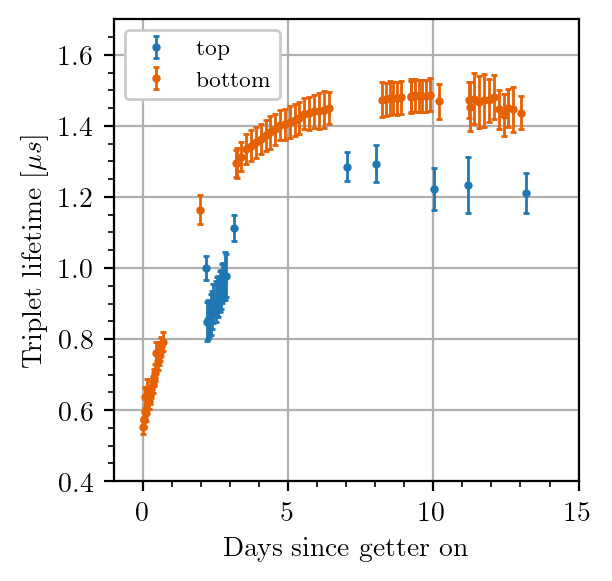

In [27]:
plt.figure(0,figsize=(3,3))
for i,p in enumerate(pos):
    plt.errorbar(days[i], np.array(triplet[i])[:,0], yerr=np.array(triplet[i])[:,1], label=p, ls='none', fmt='o', markersize=2, elinewidth=1, capsize=1)
plt.legend()
plt.xlim(-1, 15)
plt.ylim(0.4,1.7)
plt.xlabel('Days since getter on')
plt.ylabel(r'Triplet lifetime [$\mu s$]')
plt.minorticks_on()
plt.grid()